In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/Kaggle"
%cd /content/Kaggle
!kaggle datasets download -d skihikingkevin/pubg-match-deaths
!unzip \*.zip  && rm *.zip

/content/Kaggle
100% 4.10G/4.10G [01:24<00:00, 54.0MB/s]
100% 4.10G/4.10G [01:24<00:00, 52.0MB/s]
Archive:  pubg-match-deaths.zip
  inflating: aggregate/agg_match_stats_0.csv  
  inflating: aggregate/agg_match_stats_1.csv  
  inflating: aggregate/agg_match_stats_2.csv  
  inflating: aggregate/agg_match_stats_3.csv  
  inflating: aggregate/agg_match_stats_4.csv  
  inflating: deaths/kill_match_stats_final_0.csv  
  inflating: deaths/kill_match_stats_final_1.csv  
  inflating: deaths/kill_match_stats_final_2.csv  
  inflating: deaths/kill_match_stats_final_3.csv  
  inflating: deaths/kill_match_stats_final_4.csv  
  inflating: erangel.jpg             
  inflating: miramar.jpg             


## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as r
import warnings

!pip install lifelines
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

## Read CSV File into Data Frame

In [2]:
df = pd.read_csv("/content/Kaggle/aggregate/agg_match_stats_0.csv")
df_filtered = df[df["player_survive_time"] < 2100]

## Plot 1 - Team Types in Dataset


Text(0.5, 1.0, 'Team Type')

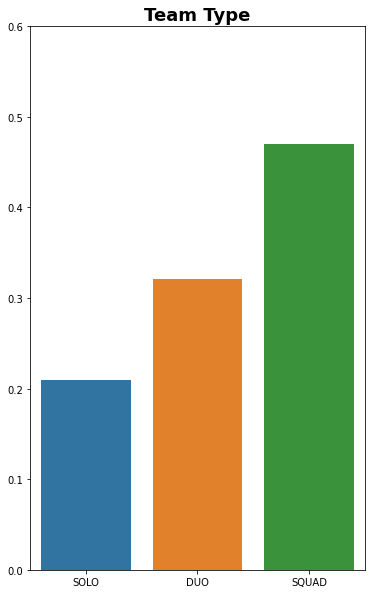

In [3]:
values = df_filtered['party_size'].value_counts(normalize=True)
arr_x = np.array(['SOLO', 'DUO', 'SQUAD'])
arr_y = np.array([0.209273, 0.320976, 0.469752])
data = np.array([arr_y, np.array(values)])

fig_dims = (6, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(x=arr_x, y=arr_y, ax=ax)
plot.set(ylim=(0, 0.6))
plot.set_title('Team Type', fontsize=18, weight='semibold')

## Plot 2 - Players Drive or Walk

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 1.0, 'Driving or not')

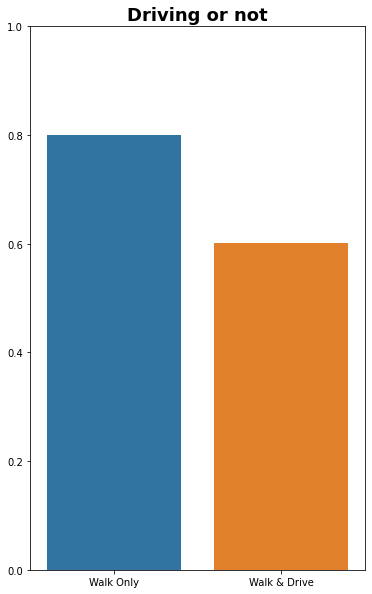

In [4]:
walking_only = df_filtered[(df_filtered["player_dist_walk"] > 0) & (df_filtered["player_dist_ride"] == 0)]
Walk_and_drive = df_filtered[(df["player_dist_walk"] > 0) & (df_filtered["player_dist_ride"] > 0)]
arr_x = np.array(["Walk Only", "Walk & Drive"])
arr_y = np.array([len(walking_only), len(Walk_and_drive)])

arr_y = arr_y/np.linalg.norm(arr_y)  # Normalize the Data to get values between 0 & 1
data = np.array([arr_y, arr_x])

fig_dims = (6, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(x=arr_x, y=arr_y, ax=ax)
plot.set(ylim=(0, 1))
plot.set_title('Driving or not', fontsize=18, weight='semibold')

## Plot 3 - Size of Game (Number of players playing at once)

Text(0.5, 1.0, 'Play Size')

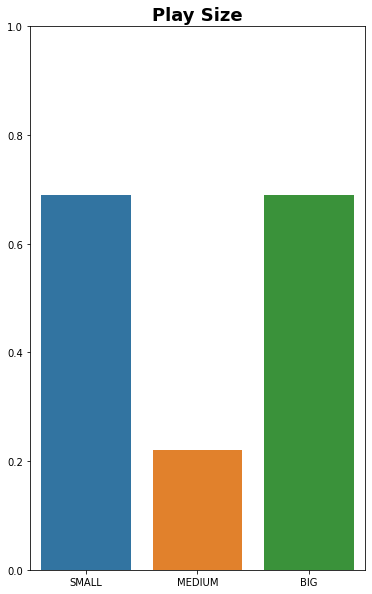

In [5]:
small_game = df_filtered["game_size"] < 33
medium_game = df_filtered[(df_filtered["game_size"] >= 33) & (df_filtered["game_size"] < 66)]
big_game = df_filtered["game_size"] >= 66

arr_x = np.array(["SMALL", "MEDIUM", "BIG"])
arr_y = np.array([len(small_game), len(medium_game), len(big_game)])

arr_y = arr_y/np.linalg.norm(arr_y)   # Normalize the data
data = np.array([arr_y, arr_x])

fig_dims = (6, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plot = sns.barplot(x=arr_x, y=arr_y, ax=ax)
plot.set(ylim=(0, 1))
plot.set_title('Play Size', fontsize=18, weight='semibold')

# Preprocessing for Survive Time and Party Size

In [8]:
mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
df_filtered_4_size = df_filtered[df_filtered['party_size'] == 4]
Columns = ['player_survive_time', 'party_size']
X = mean.fit_transform(df_filtered_4_size[Columns])
df_X = pd.DataFrame(X,
                    columns = Columns)
keep = ['player_survive_time', 'party_size']
df_keepcolumn = df_filtered_4_size[keep]
df = pd.concat([df_keepcolumn, df_X], axis = 1)
df = df.dropna() 
print(df.isnull().sum())  # Print isnull present or not
print(df.shape)

player_survive_time    0
party_size             0
player_survive_time    0
party_size             0
dtype: int64
(3064935, 4)


## Plot 4 - Kaplan Meier Analysis for Survival Rate based on Team Size

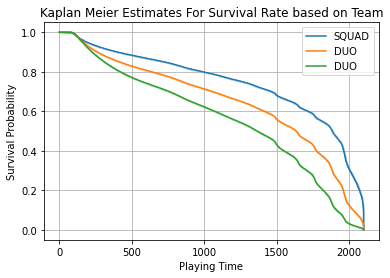

In [9]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf4 = KaplanMeierFitter()
X= df_filtered['player_survive_time']
Y1 = df_filtered['party_size'] == 1
Y2 = df_filtered['party_size'] == 2
Y4 = df_filtered['party_size'] == 4

kmf1.fit(X, event_observed = Y1)
kmf2.fit(X, event_observed = Y2)
kmf4.fit(X, event_observed = Y4)
kmf1.plot()
kmf2.plot()
kmf4.plot()

plt.grid()
plt.title("Kaplan Meier Estimates For Survival Rate based on Team")
plt.xlabel("Playing Time")
plt.ylabel("Survival Probability")
plt.legend(['SQUAD', 'DUO', 'DUO']) 
plt.show()